In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import torch
import tqdm
import torch.optim as optim
from torch.utils.data import Dataset
import keras
import os
import cv2
from torchvision import transforms
from sklearn.model_selection import train_test_split


TRAIN_DATA_PATH = '/kaggle/input/airbus-ship-detection/train_v2'
TEST_DATA_PATH = '/kaggle/input/airbus-ship-detection/test_v2'
IMAGES_WITHOUT_SHIPS = 20000
IMAGES_WITH_SHIPS = 25000

### **Data preprocessing**

#### **Сreating transformations**

In [4]:
output_size = (256, 256)

rescale_transform = transforms.Resize(output_size)
composed_transform = rescale_transform,rescale_transform

#### **Data split**

In [5]:
MASKS_DF = pd.read_csv("/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv")
MASKS_DF['Ship_class'] = MASKS_DF['EncodedPixels'].notnull().astype(int)
#Deleting the corrupted image
MASKS_DF = MASKS_DF.drop(MASKS_DF[MASKS_DF['ImageId'] == '6384c3e78.jpg'].index)

no_ship_imgs = MASKS_DF[MASKS_DF['Ship_class'] == 0].sample(frac=1).sample(n=IMAGES_WITHOUT_SHIPS)
no_ship_imgs = no_ship_imgs.drop('Ship_class', axis=1)
no_ship_imgs.reset_index(drop=True,inplace=True)

ship_imgs = MASKS_DF[MASKS_DF['Ship_class'] == 1]
ship_imgs = ship_imgs.groupby('ImageId')[['EncodedPixels']].agg(lambda rle_encoded_px: ' '.join(rle_encoded_px)).sample(frac=1).sample(n=IMAGES_WITH_SHIPS)
ship_imgs.reset_index(inplace=True)

ship_imgs.shape, no_ship_imgs.shape

((25000, 2), (20000, 2))

In [57]:
ship_imgs[:10]

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
2,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
3,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...
4,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...
5,000532683.jpg,458957 14 459725 14 460493 14 461261 14 462029...
6,00053c6ba.jpg,565382 3 566144 9 566909 12 567677 13 568445 1...
7,0005d01c8.jpg,56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...
8,0005d6d95.jpg,265143 1 265910 4 266678 5 267445 7 268212 10 ...
9,0006c52e8.jpg,146366 1 147132 4 147899 5 148666 7 149432 10 ...


In [58]:
no_ship_imgs[:10]

,ImageId,EncodedPixels
0,9718592f7.jpg,NaN
1,1a40fcba3.jpg,NaN
2,416c02cd2.jpg,NaN
3,4aebd4db4.jpg,NaN
4,84fb20e69.jpg,NaN
5,ae22d7460.jpg,NaN
6,94cbc38d0.jpg,NaN
7,817a60f24.jpg,NaN
8,8d3d68974.jpg,NaN
9,70226051f.jpg,NaN


In [6]:
all_images = np.concatenate((ship_imgs['ImageId'].values, no_ship_imgs['ImageId'].values))
train, test_ids = train_test_split(all_images, test_size=0.1, random_state=42)
train_ids, dev_ids = train_test_split(train, test_size=0.11, random_state=42)

train_ids.shape, dev_ids.shape, test_ids.shape

((36045,), (4455,), (4500,))

#### **Mask decoding utils**

In [50]:
def rle_decoder(encoded_px_str):
    """
    Decode a string of run-length encoded pixels.
    Args:
        encoded_px_str (str): String of encoded pixels in the format "start length start length ...".
    Returns:
        list: Decoded pixels as a list of coordinate tuples (x, y).
    """
    decoded_px = []
    temp_lst = encoded_px_str.split()
    encoded_px = np.array([(int(temp_lst[idx]), int(temp_lst[idx+1])) for idx in range(0, len(temp_lst) - 1, 2)])
    for pair in encoded_px:
        for interm_px in range(pair[0], pair[0]+pair[1]):
            st_position = min(interm_px % 768,766), min(interm_px // 768, 766)
            decoded_px.append(st_position)
            
    return decoded_px

def mask_img(mask_pnts, shape=(768, 768)):
    """
    Create a binary mask image from a list of mask points.
    Args:
        mask_pnts (list): List of coordinate tuples (x, y) representing mask points.
        shape (tuple, optional): Shape of the mask image. Defaults to (768, 768).
    Returns:
        ndarray: Binary mask image as a NumPy array.
    """
    mask_image = np.zeros(shape)
    for point in mask_pnts:
        mask_image[point] = 1
    return mask_image

def one_hot_encoder(mask, num_classes=2):
    """
    One-hot encode a mask image.
    Args:
        mask (ndarray): Mask image as a NumPy array.
        num_classes (int, optional): Number of classes. Defaults to 2.
    Returns:
        ndarray: One-hot encoded mask as a NumPy array.
    """
    return np.squeeze(np.eye(num_classes)[mask])

def rle_to_mask(encoded_pixels):
    """
    Convert run-length encoded pixels to a mask image.
    Args:
        encoded_pixels (str): String of run-length encoded pixels.
    Returns:
        ndarray: Mask image as a NumPy array.
    """
    return mask_img(rle_decoder(encoded_pixels))

def mask_to_rel(mask, shape=(768,768)):
    """
    Convert a binary mask to its corresponding Run-Length Encoding (RLE) representation.
    Args:
        mask (ndarray): Binary mask array.   
    Returns:
        str: RLE representation of the mask.
    """
    if mask.shape != shape:
        mask = cv2.resize(mask, shape, interpolation=cv2.INTER_NEAREST)
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    runs[::2] -= 1
    return ' '.join(str(x) for x in runs)

def predict_mask(model, image):
    """
    Generate a prediction mask for a given input image using a trained model.
    Args:
        model (Keras model): Trained model.
        image (ndarray): Input image array.
    Returns:
        ndarray: Predicted mask array.
    """
    if not isinstance(image, np.ndarray):
        image = np.array(image)

    image = np.expand_dims(image, axis=0) / 255.0
    pred_mask = model.predict(image).argmax(axis=-1)[0]
    return pred_mask


In [89]:
values = MASKS_DF.loc[MASKS_DF['ImageId'] == train_ids[1000], 'EncodedPixels'].values
rle_string = ' '.join(map(lambda x: x, values))

msk = rle_to_mask(rle_string)
encoded_rle = mask_to_rel(msk)
encoded_rle, rle_string =encoded_rle.split(' '), rle_string.split(' ')
encoded_rle == rle_string

True

Text(0.5, 1.0, '66c7c3361.jpg')

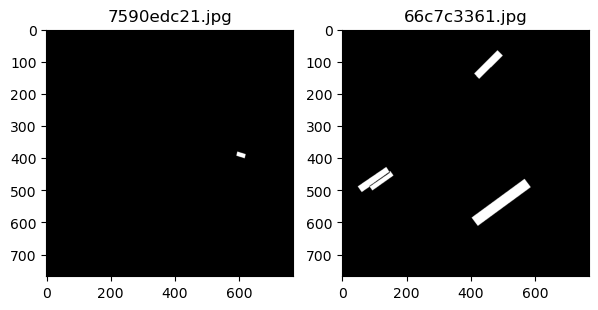

In [19]:
msk_obj_1 =rle_to_mask(ship_imgs['EncodedPixels'][200])
msk_obj_2 = rle_to_mask(ship_imgs['EncodedPixels'][100])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.imshow(msk_obj_1, cmap='gray')
ax1.set_title(ship_imgs['ImageId'][200])

ax2.imshow(msk_obj_2, cmap='gray')
ax2.set_title(ship_imgs['ImageId'][100])

### **Dataset and DataGenerator classes**

In [8]:
class ImageDataset(Dataset):
    
    def __init__(self, data_folder, img_ids, masks, transform=None):
        """
        A custom PyTorch dataset for image data.
        Args:
            data_folder (str): Path to the folder containing the image data.
            img_ids (numpy array): List of image IDs.
            masks (pandas dataframe): Dictionary or list of masks corresponding to the image IDs.
            transform (callable, optional): Optional data transformation to be applied to the images and masks.
        """
        self.transform = transform
        self.folder_path = data_folder
        self.img_ids = img_ids
        self.masks = masks

    def __len__(self):
        """
        Get the total number of samples in the dataset.
        Returns:
            int: Number of samples in the dataset.
        """
        return len(self.img_ids)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset at the specified index.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: A tuple (tensor_img, label) containing the image tensor and the label tensor.
        """
        path = os.path.join(self.folder_path, self.img_ids[idx])
        try:
            img = PIL.Image.open(path).convert('RGB') 
        except Exception as e:
            raise Exception(f"Failed to load the image with the next ID: {path}") from e
        msk = self.getlabel(self.img_ids[idx])
        tensor_img = transforms.ToTensor()(img)
        tensor_msk = transforms.ToTensor()(msk)
            
        if self.transform is not None:
            tensor_img = self.transform[0](tensor_img).T
            tensor_msk = self.transform[1](tensor_msk).T

        tensor_msk = tensor_msk.to(torch.int)
        label = one_hot_encoder(tensor_msk)
        
        return tensor_img, label
    
    def getlabel(self, img_id):
        """
        Get the label(mask) corresponding to the given image ID.
        Args:
            img_id (str): Image ID for which to retrieve the mask.
        Returns:
            ndarray: Mask as a numpy array.
        """
        encoded_pd = self.masks.loc[self.masks['ImageId'] == img_id, 'EncodedPixels'].values
        if not str(encoded_pd[0]) == 'nan':
            encoded_pd = ' '.join(map(lambda x: x, encoded_pd))
            msk_obj = rle_to_mask(encoded_pd)
        else:
            msk_obj = np.zeros((768,768))
            
        return msk_obj
    
    def getImgandMask(self, idx):
        """
         Get the image, mask, and image ID at the specified index.
        Args:
            idx (int): Index of the sample to retrieve.
        Returns:
            tuple: A tuple (img, msk, img_id) containing the image, mask, and image ID.
        """
        img_id = self.img_ids[idx]
        path = os.path.join(self.folder_path, img_id)
        img = np.array(PIL.Image.open(path).convert('RGB'))
        msk = self.getlabel(img_id)
        return img, msk, img_id
    
class DataGenerator(keras.utils.Sequence):
    def __init__(self, dataset, batch_size=32, shuffle=True):
        """
        A custom Keras data generator.
        Args:
            dataset (ImageDataset): An instance of the ImageDataset class or any other dataset class.
            batch_size (int, optional): Batch size for generating data.
            shuffle (bool, optional): Whether to shuffle the data at the end of each epoch.
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """
        Get the total number of batches in the data generator.
        Returns:
            int: Number of batches in the data generator.
        """
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        """
        Get a batch of data at the specified index.
        Args:
            index (int): Index of the batch to retrieve.
        Returns:
            tuple: A tuple (inputs, labels) containing the inputs and labels for the batch.
        """
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        inputs = []
        labels = []
        for idx in indexes:
            input_data, target_data = self.dataset[idx]
            inputs.append(input_data/255)  
            labels.append(target_data) 

        inputs = np.stack(inputs)
        labels = np.stack(labels)
        return inputs, labels

    def on_epoch_end(self):
        """
        Shuffle the dataset at the end of each epoch.
        """
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

#### **Dataset class**

In [13]:
train_data = ImageDataset(TRAIN_DATA_PATH, train_ids, MASKS_DF, transform=composed_transform)
train_data[0][0].shape, train_data[0][1].shape

(torch.Size([256, 256, 3]), (256, 256, 2))

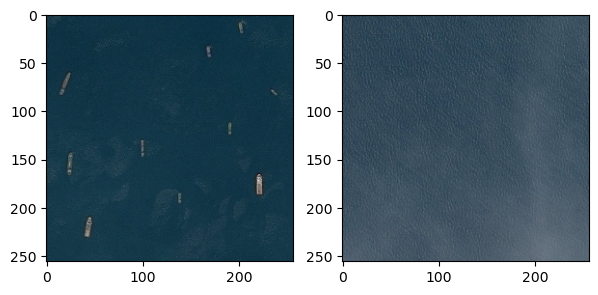

In [12]:
img_1, img_2 = train_data[100][0], train_data[1500][0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.imshow(img_1)
ax2.imshow(img_2)


Text(0.5, 1.0, '75f032bee.jpg-masked')

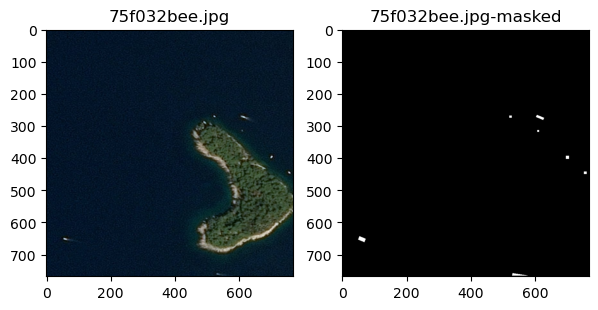

In [8]:
img, mask, img_id = train_data.getImgandMask(1000)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.imshow(img)
ax1.set_title(img_id)

ax2.imshow(mask, cmap='gray')
ax2.set_title(f'{img_id}-masked')

Text(0.5, 1.0, 'ff58b7dbb.jpg-masked')

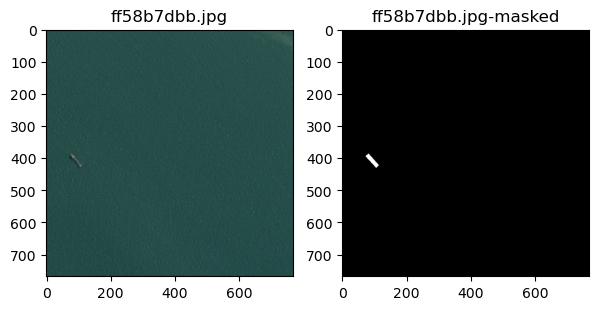

In [10]:
img, mask, img_id = train_data.getImgandMask(6000)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.imshow(img)
ax1.set_title(img_id)

ax2.imshow(mask, cmap='gray')
ax2.set_title(f'{img_id}-masked')

In [14]:
dev_data = ImageDataset(TRAIN_DATA_PATH, dev_ids, MASKS_DF, transform=composed_transform)
test_data = ImageDataset(TRAIN_DATA_PATH, test_ids, MASKS_DF, transform=composed_transform)

dev_data[0][0].shape, dev_data[0][1].shape, test_data[0][0].shape, test_data[0][1].shape

(torch.Size([256, 256, 3]),
 (256, 256, 2),
 torch.Size([256, 256, 3]),
 (256, 256, 2))

In [12]:
print(f'Amount of test examples: {len(test_data)}')
print(f'Amount of validation examples: {len(dev_data)}')

Amount of test examples: 4500
Amount of validation examples: 4455


#### **DataGenerator class**

In [15]:
train_generator = DataGenerator(train_data)  
dev_generator = DataGenerator(dev_data)
test_generator = DataGenerator(test_data)

### **Modeling part**

#### **Model architecture**

In [16]:
import tensorflow as tf
from keras.metrics import Recall

def doubConv(x, filters_num):
    """
    Double convolution block.
    Args:
        x (Tensor): Input tensor.
        filters_num (int): Number of filters for the convolution layers.
    Returns:
        Tensor: Output tensor after applying two convolution layers.
    """
    x = tf.keras.layers.Conv2D(filters_num, 3, padding = "same", activation = tf.keras.activations.relu, kernel_initializer = "he_normal")(x)
    x = tf.keras.layers.Conv2D(filters_num, 3, padding = "same", activation = tf.keras.activations.relu, kernel_initializer = "he_normal")(x)
    return x

def downsample(x, filters_num):
    """
    Downsample block.
    Args:
        x (Tensor): Input tensor.
        filters_num (int): Number of filters for the convolution layers.
    Returns:
        Tensor: Output tensor after downsampling.
    """
    conv = doubConv(x, filters_num)
    pool = tf.keras.layers.MaxPool2D(2)(conv)
    pool = tf.keras.layers.Dropout(0.4)(pool)
    return conv, pool

def upsample(x, conv, filters_num):
    """
    Upsample block.
    Args:
        x (Tensor): Input tensor.
        conv (Tensor): Tensor from the corresponding downsample block.
        filters_num (int): Number of filters for the convolution layers.
    Returns:
        Tensor: Output tensor after upsampling.
    """
    x = tf.keras.layers.Conv2DTranspose(filters_num, 3, 2, padding="same")(x)
    x = tf.keras.layers.concatenate([x, conv])
    x = tf.keras.layers.Dropout(0.4)(x)
    x = doubConv(x, filters_num)
    return x

In [17]:
def get_UNET_acrhitecture():
    """
    Creates and returns the UNET's acrhitecture.
    Returns:
      tf.keras.Model: UNET model
    """
    # input layer
    input_layer = tf.keras.layers.Input(shape=(256,256,3))
    # downsampling process
    conv1, pool1 = downsample(input_layer, 64)
    conv2, pool2 = downsample(pool1, 128)
    conv3, pool3 = downsample(pool2, 256)
    conv4, pool4 = downsample(pool3, 512)

    bottleneck = doubConv(pool4, 1024)
    # upsampling process
    uconv4 = upsample(bottleneck, conv4, 512)
    uconv3 = upsample(uconv4, conv3, 256)
    uconv2 = upsample(uconv3, conv2, 128)
    uconv1 = upsample(uconv2, conv1, 64)
    # output layer
    output_layer = tf.keras.layers.Conv2D(2, 1, padding="same", activation = tf.keras.activations.softmax)(uconv1)
    UNET = tf.keras.Model(input_layer, output_layer)

    return UNET

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    """
    Compute the Dice coefficient between ground truth and predicted masks.
    Args:
        y_true : Ground truth mask.
        y_pred : Predicted mask.
        smooth (float): Smoothing factor to avoid division by zero.
    Returns:
        Dice coefficient.
    """
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

#### **Model's training stage**

In [18]:
def plot_history(history):
    fig, axs = plt.subplots(2, 2, figsize=(13, 10))

    axs[0, 0].plot(history.history['loss'])
    axs[0, 0].plot(history.history['val_loss'])
    axs[0, 0].set_title('Model loss')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Validation'], loc='upper left')

    axs[0, 1].plot(history.history['accuracy'])
    axs[0, 1].plot(history.history['val_accuracy'])
    axs[0, 1].set_title('Model accuracy')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Validation'], loc='upper left')
    
    axs[1, 0].plot(history.history['dice_coefficient'])
    axs[1, 0].plot(history.history['val_dice_coefficient'])
    axs[1, 0].set_title('Model dice coefficient')
    axs[1, 0].set_ylabel('Dice coefficient')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend(['Train', 'Validation'], loc='upper left')
    
    axs[1, 1].plot(history.history['recall'])
    axs[1, 1].plot(history.history['val_recall'])
    axs[1, 1].set_title('Model recall value')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend(['Train', 'Validation'], loc='upper left')

In [19]:
recall = Recall()
model = get_UNET_acrhitecture()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', dice_coefficient, recall])
tf.keras.utils.get_custom_objects()['dice_coefficient'] = dice_coefficient

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [20]:
history = model.fit(train_generator, validation_data=dev_generator, epochs=2)

Epoch 1/2


2023-06-05 16:15:47.970255: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1126/1126 [==============================] - 2546s 2s/step - loss: 0.0845 - accuracy: 0.9968 - dice_coefficient: 0.9832 - recall: 0.9968 - val_loss: 0.0181 - val_accuracy: 0.9972 - val_dice_coefficient: 0.9941 - val_recall: 0.9972
Epoch 2/2
1126/1126 [==============================] - 2276s 2s/step - loss: 0.0144 - accuracy: 0.9972 - dice_coefficient: 0.9948 - recall: 0.9972 - val_loss: 0.0110 - val_accuracy: 0.9973 - val_dice_coefficient: 0.9954 - val_recall: 0.9973


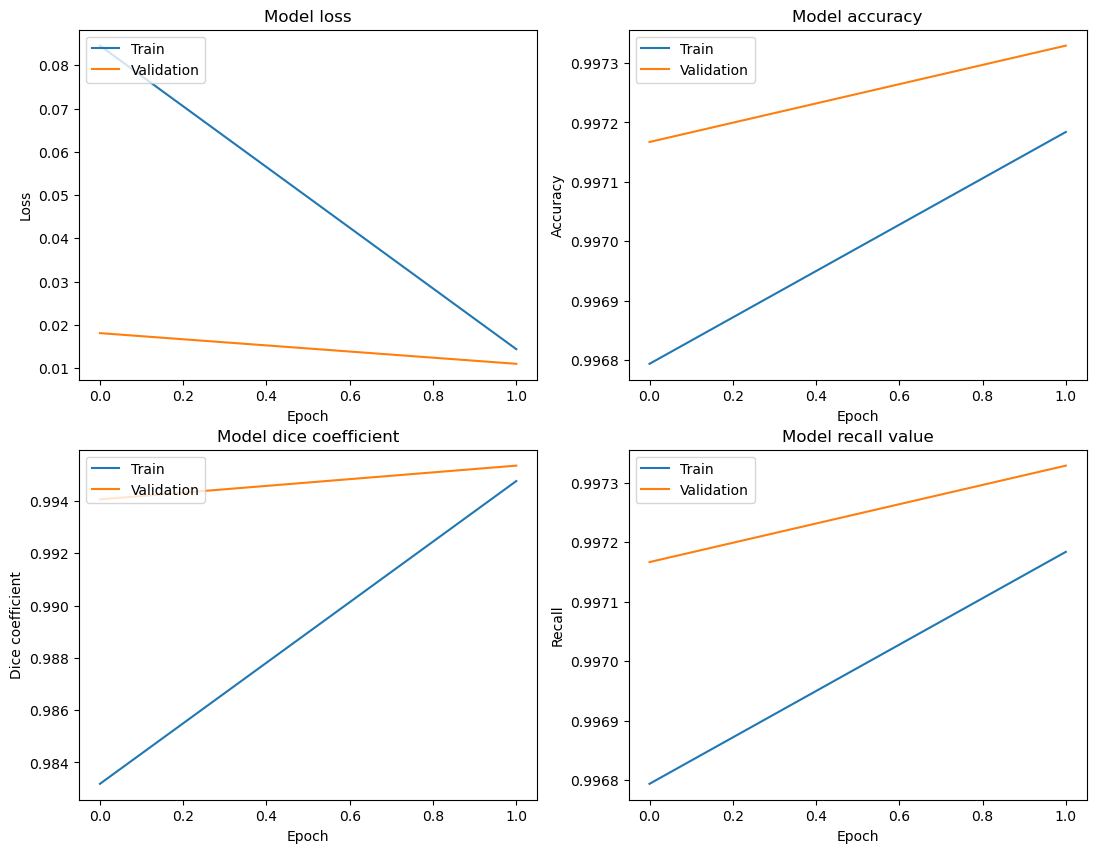

In [21]:
plot_history(history)

#### **Evaluation on the test set**

In [22]:
metrics = model.evaluate(test_generator)
print(f'Test accuracy: {metrics[1]}\nTest dice coefficient: {metrics[2]}\nRecall: {metrics[3]}')

140/140 [==============================] - 265s 2s/step - loss: 0.0113 - accuracy: 0.9972 - dice_coefficient: 0.9951 - recall: 0.9972
Test accuracy: 0.9971750378608704
Test dice coefficient: 0.9950985312461853
Recall: 0.9971745014190674


1/1 [==============================] - 0s 20ms/step


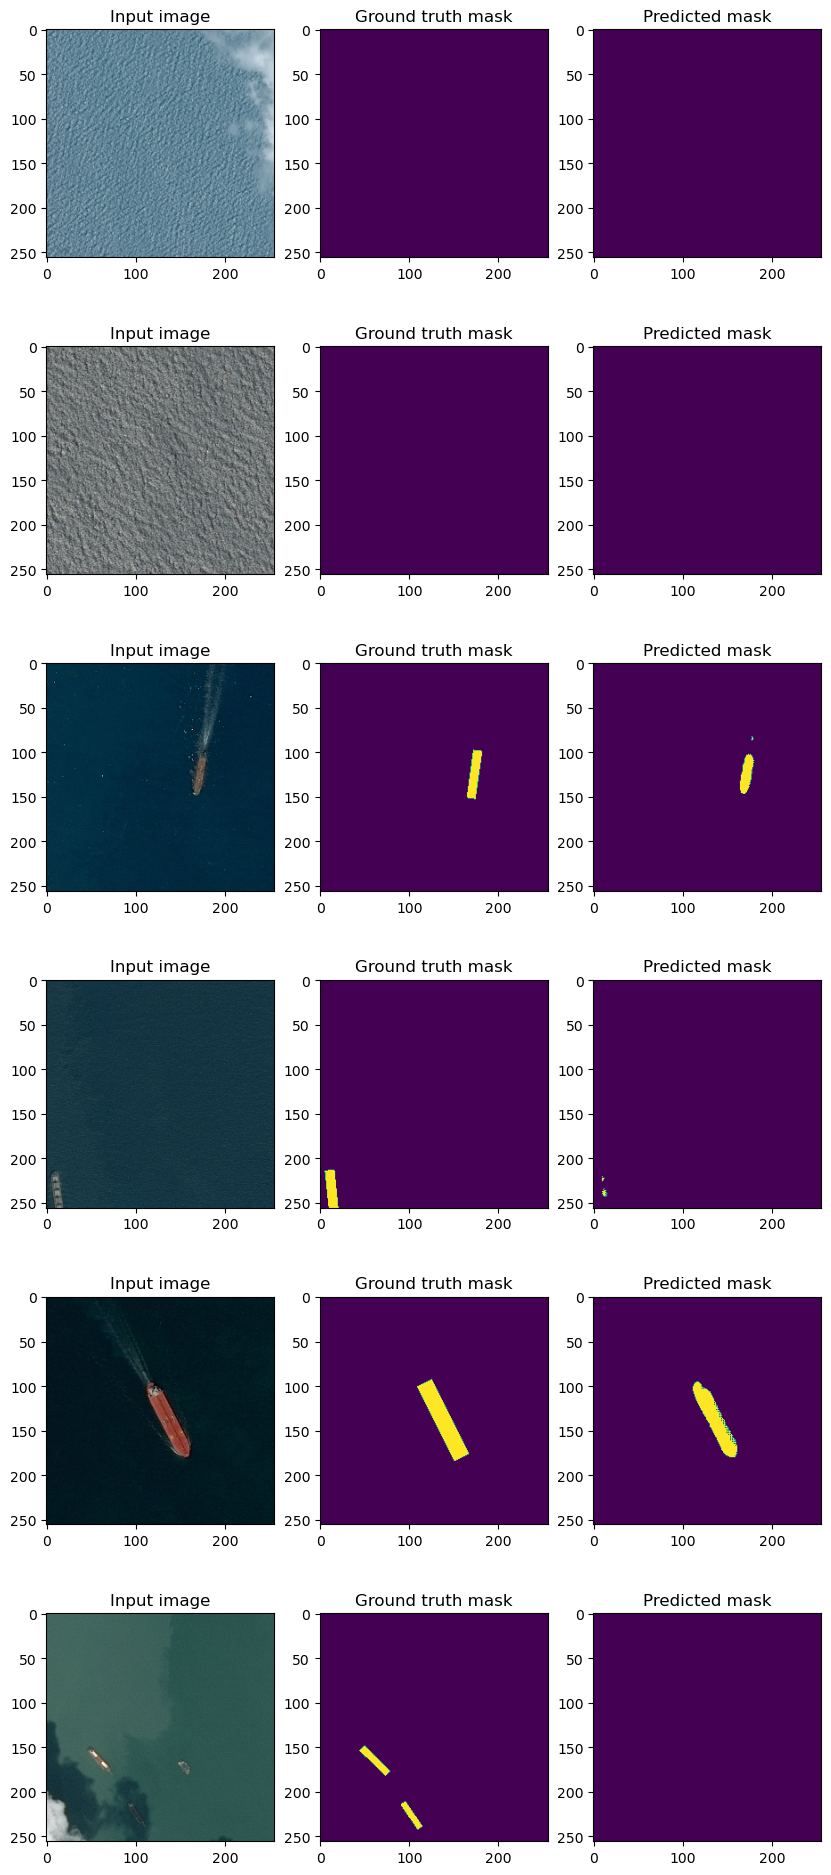

In [31]:
fig, axes = plt.subplots(6, 3, figsize=(10, 4*6))
for idx in range(6):
    image, grt_mask = test_data[4*idx]
    grt_mask = grt_mask.argmax(axis=-1)
    pred_mask = predict_mask(model, image)

    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title('Input image')
    axes[idx, 1].imshow(grt_mask)
    axes[idx, 1].set_title('Ground truth mask')
    axes[idx, 2].imshow(pred_mask)
    axes[idx, 2].set_title('Predicted mask')

#### **Model saving**

In [32]:
model.save('model-UNET.h5')

### **Model inference**

In [33]:
model = tf.keras.models.load_model('/kaggle/working/model-UNET.h5')

In [51]:
predictions_df = pd.DataFrame(columns=['ImageId', 'EncodedPixels'])

for filename in os.listdir(TEST_DATA_PATH)[:3]:
    file_path = os.path.join(TEST_DATA_PATH, filename)
    image = PIL.Image.open(file_path)
    image = image.resize((256, 256))  

    pred_mask = predict_mask(model, image)
    rle_mask = mask_to_rel(pred_mask)

    predictions_df = predictions_df.append({'ImageId': filename, 'EncodedPixels': rle_mask}, ignore_index=True)

predictions_df.to_csv('sample_submission.csv', index=False)

1/1 [==============================] - 0s 28ms/step


/tmp/ipykernel_28/1833163732.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'ImageId': filename, 'EncodedPixels': rle_mask}, ignore_index=True)
/tmp/ipykernel_28/1833163732.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'ImageId': filename, 'EncodedPixels': rle_mask}, ignore_index=True)
/tmp/ipykernel_28/1833163732.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append({'ImageId': filename, 'EncodedPixels': rle_mask}, ignore_index=True)
